In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.utils import shuffle
from collections import OrderedDict
from collections import Counter
from scipy.special import expit
from itertools import compress
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
hdfs_data= pd.read_csv('HDFS_100k.log_structured.csv')

In [75]:
anomaly_labels = pd.read_csv('anomaly_label.csv')

In [76]:
hdfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   LineId         104815 non-null  int64 
 1   Date           104815 non-null  int64 
 2   Time           104815 non-null  int64 
 3   Pid            104815 non-null  int64 
 4   Level          104815 non-null  object
 5   Component      104815 non-null  object
 6   Content        104815 non-null  object
 7   EventId        104815 non-null  object
 8   EventTemplate  104815 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.2+ MB


In [77]:
hdfs_data.head()

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating


In [78]:
hdfs_data['BlockId']=hdfs_data['Content'].str.findall(r'(blk_-?\d+)').apply(lambda x:x[0])

In [79]:
hdfs_data

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,BlockId
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,blk_-1608999687919862906
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating,blk_-1608999687919862906
...,...,...,...,...,...,...,...,...,...,...
104810,104811,81109,210122,13,INFO,dfs.DataBlockScanner,Verification succeeded for blk_-87387097785867...,E2,Verification succeeded for <*>,blk_-8738709778586756237
104811,104812,81109,210124,13,INFO,dfs.DataBlockScanner,Verification succeeded for blk_642047611142564...,E2,Verification succeeded for <*>,blk_6420476111425645508
104812,104813,81109,210126,13,INFO,dfs.DataBlockScanner,Verification succeeded for blk_-23823897510323...,E2,Verification succeeded for <*>,blk_-2382389751032389929
104813,104814,81109,210126,13,INFO,dfs.DataBlockScanner,Verification succeeded for blk_485603173001003...,E2,Verification succeeded for <*>,blk_4856031730010032819


In [80]:
hdfs_data['Date'].value_counts()

81109    104815
Name: Date, dtype: int64

In [81]:
hdfs_data=hdfs_data.drop(columns='Date')

In [82]:
anomaly_labels.head()

,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [83]:
anomaly_labels['BlockId']

0         blk_-1608999687919862906
1          blk_7503483334202473044
2         blk_-3544583377289625738
3         blk_-9073992586687739851
4          blk_7854771516489510256
                    ...           
575056     blk_1019720114020043203
575057    blk_-2683116845478050414
575058     blk_5595059397348477632
575059     blk_1513937873877967730
575060    blk_-9128742458709757181
Name: BlockId, Length: 575061, dtype: object

In [84]:
hdfs_data.shape

(104815, 9)

In [85]:
df_hdfs=hdfs_data.merge(anomaly_labels, left_on='BlockId',right_on='BlockId')

In [86]:
df_hdfs.head()

,LineId,Time,Pid,Level,Component,Content,EventId,EventTemplate,BlockId,Label
0,1,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906,Normal
1,2,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,blk_-1608999687919862906,Normal
2,3,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906,Normal
3,4,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906,Normal
4,5,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating,blk_-1608999687919862906,Normal


In [87]:
df_hdfs['EventId'].value_counts()

E5     23671
E26    23478
E11    23451
E9     23447
E22     7940
E2      2183
E3       407
E7        68
E6        31
E18       27
E25       27
E16       27
E13       24
E21       23
E14        4
E10        3
E15        2
E27        1
E8         1
Name: EventId, dtype: int64

In [88]:
df_hdfs['Label'].value_counts()

Normal     101544
Anomaly      3271
Name: Label, dtype: int64

In [3]:



class Iterator(Dataset):
    def __init__(self, data_dict, batch_size=32, shuffle=False, num_workers=1):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.iter = DataLoader(dataset=self, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def __getitem__(self, index):
        return {k: self.data_dict[k][index] for k in self.keys}

    def __len__(self):
        return self.data_dict["SessionId"].shape[0]

class Vectorizer(object):

    def fit_transform(self, x_train, window_y_train, y_train):
        self.label_mapping = {eid: idx for idx, eid in enumerate(window_y_train.unique(), 2)}
        self.label_mapping["#OOV"] = 0
        self.label_mapping["#Pad"] = 1
        self.num_labels = len(self.label_mapping)
        return self.transform(x_train, window_y_train, y_train)

    def transform(self, x, window_y, y):
        x["EventSequence"] = x["EventSequence"].map(lambda x: [self.label_mapping.get(item, 0) for item in x])
        window_y = window_y.map(lambda x: self.label_mapping.get(x, 0))
        y = y
        data_dict = {"SessionId": x["SessionId"].values, "window_y": window_y.values, "y": y.values, "x": np.array(x["EventSequence"].tolist())}
        return data_dict
        

class FeatureExtractor(object):

    def __init__(self):
        self.idf_vec = None
        self.mean_vec = None
        self.events = None
        self.term_weighting = None
        self.normalization = None
        self.oov = None

    def fit_transform(self, X_seq, term_weighting=None, normalization=None, oov=False, min_count=1):
        """ 
            Подгонка и преобразование матрицы данных
        Аргументы
        ---------
            X_seq: ndarray, матрица лог-последовательностей
            взвешивание_термина: Нет или `tf-idf`
            нормализация: Нет или `zero-mean`
            oov: bool, использовать ли OOV события
            min_count: int, минимальное количество событий (по умолчанию 0), действительно только при oov=True.
        Возвращает
        -------
            X_new: преобразованная матрица данных
        """
        print('====== Transformed train data summary ======')
        self.term_weighting = term_weighting
        self.normalization = normalization
        self.oov = oov

        X_counts = []
        for i in range(X_seq.shape[0]):
            event_counts = Counter(X_seq[i])
            X_counts.append(event_counts)
        X_df = pd.DataFrame(X_counts)
        X_df = X_df.fillna(0)
        self.events = X_df.columns
        X = X_df.values
        if self.oov:
            oov_vec = np.zeros(X.shape[0])
            if min_count > 1:
                idx = np.sum(X > 0, axis=0) >= min_count
                oov_vec = np.sum(X[:, ~idx] > 0, axis=1)
                X = X[:, idx]
                self.events = np.array(X_df.columns)[idx].tolist()
            X = np.hstack([X, oov_vec.reshape(X.shape[0], 1)])
        
        num_instance, num_event = X.shape
        if self.term_weighting == 'tf-idf':
            df_vec = np.sum(X > 0, axis=0)
            self.idf_vec = np.log(num_instance / (df_vec + 1e-8))
            idf_matrix = X * np.tile(self.idf_vec, (num_instance, 1)) 
            X = idf_matrix
        if self.normalization == 'zero-mean':
            mean_vec = X.mean(axis=0)
            self.mean_vec = mean_vec.reshape(1, num_event)
            X = X - np.tile(self.mean_vec, (num_instance, 1))
        elif self.normalization == 'sigmoid':
            X[X != 0] = expit(X[X != 0])
        X_new = X
        
        print('Train data shape: {}-by-{}\n'.format(X_new.shape[0], X_new.shape[1])) 
        return X_new

    def transform(self, X_seq):
        """ 
            Преобразование матрицы данных с обученными параметрами
        Аргументы
        ---------
            X: матрица лог-последовательностей
            взвешивание_термина: Нет или `tf-idf`.
        Возвращает
        -------
            X_new: матрица преобразованных данных
        """
        print('====== Transformed test data summary ======')
        X_counts = []
        for i in range(X_seq.shape[0]):
            event_counts = Counter(X_seq[i])
            X_counts.append(event_counts)
        X_df = pd.DataFrame(X_counts)
        X_df = X_df.fillna(0)
        empty_events = set(self.events) - set(X_df.columns)
        for event in empty_events:
            X_df[event] = [0] * len(X_df)
        X = X_df[self.events].values
        if self.oov:
            oov_vec = np.sum(X_df[X_df.columns.difference(self.events)].values > 0, axis=1)
            X = np.hstack([X, oov_vec.reshape(X.shape[0], 1)])
        
        num_instance, num_event = X.shape
        if self.term_weighting == 'tf-idf':
            idf_matrix = X * np.tile(self.idf_vec, (num_instance, 1)) 
            X = idf_matrix
        if self.normalization == 'zero-mean':
            X = X - np.tile(self.mean_vec, (num_instance, 1))
        elif self.normalization == 'sigmoid':
            X[X != 0] = expit(X[X != 0])
        X_new = X

        print('Test data shape: {}-by-{}\n'.format(X_new.shape[0], X_new.shape[1])) 

        return X_new

In [89]:
def _split_data(x_data, y_data=None, train_ratio=0, split_type='uniform'): #uniform sequential
    if split_type == 'uniform' and y_data is not None:
        pos_idx = y_data > 0
        x_pos = x_data[pos_idx]
        y_pos = y_data[pos_idx]
        x_neg = x_data[~pos_idx]
        y_neg = y_data[~pos_idx]
        train_pos = int(train_ratio * x_pos.shape[0])
        train_neg = int(train_ratio * x_neg.shape[0])
        x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
        y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
        x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
        y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])
    elif split_type == 'sequential':
        num_train = int(train_ratio * x_data.shape[0])
        x_train = x_data[0:num_train]
        x_test = x_data[num_train:]
        if y_data is None:
            y_train = None
            y_test = None
        else:
            y_train = y_data[0:num_train]
            y_test = y_data[num_train:]
    # Random shuffle
    indexes = shuffle(np.arange(x_train.shape[0]))
    x_train = x_train[indexes]
    if y_train is not None:
        y_train = y_train[indexes]
    return (x_train, y_train), (x_test, y_test)
#--------------------------------------------------------------------------------------------
def load_HDFS(log_file, label_file=None, window='session', train_ratio=0.5, split_type='sequential',
              save_csv=False, window_size=0):
    

    print('====== Input data summary ======')

#     if log_file.endswith('.npz'):
#         # Split training and validation set in a class-uniform way
#         data = np.load(log_file, allow_pickle=True)
#         x_data = data['x_data']
#         y_data = data['y_data']
#         (x_train, y_train), (x_test, y_test) = _split_data(x_data, y_data, train_ratio, split_type)

    if log_file.endswith('.csv'):
        assert window == 'session', "Only window=session is supported for HDFS dataset."
        print("Loading", log_file)
        struct_log = pd.read_csv(log_file, engine='c',
                na_filter=False, memory_map=True)
        data_dict = OrderedDict()
        for idx, row in struct_log.iterrows():
            blkId_list = re.findall(r'(blk_-?\d+)', row['Content'])
            blkId_set = set(blkId_list)
            for blk_Id in blkId_set:
                if not blk_Id in data_dict:
                    data_dict[blk_Id] = []
                data_dict[blk_Id].append(row['EventId'])
        data_df = pd.DataFrame(list(data_dict.items()), columns=['BlockId', 'EventSequence'])
        
        if label_file:
            # Split training and validation set in a class-uniform way
            label_data = pd.read_csv(label_file, engine='c', na_filter=False, memory_map=True)
            label_data = label_data.set_index('BlockId')
            label_dict = label_data['Label'].to_dict()
            data_df['Label'] = data_df['BlockId'].apply(lambda x: 1 if label_dict[x] == 'Anomaly' else 0)

            # Split train and test data
            (x_train, y_train), (x_test, y_test) = _split_data(data_df['EventSequence'].values, 
                data_df['Label'].values, train_ratio, split_type)
            print(y_train.sum(), y_test.sum())
            

#         if save_csv:
#             data_df.to_csv('data_instances.csv', index=False)

        if window_size > 0:
            x_train, window_y_train, y_train = slice_hdfs(x_train, y_train, window_size)
            x_test, window_y_test, y_test = slice_hdfs(x_test, y_test, window_size)
            log = "{} {} windows ({}/{} anomaly), {}/{} normal"
            print(log.format("Train:", x_train.shape[0], y_train.sum(), y_train.shape[0], (1-y_train).sum(), y_train.shape[0]))
            print(log.format("Test:", x_test.shape[0], y_test.sum(), y_test.shape[0], (1-y_test).sum(), y_test.shape[0]))
            return (x_train, window_y_train, y_train), (x_test, window_y_test, y_test)

#         if label_file is None:
#             if split_type == 'uniform':
#                 split_type = 'sequential'
#                 print('Warning: Only split_type=sequential is supported \
#                 if label_file=None.'.format(split_type))
#             # Split training and validation set sequentially
#             x_data = data_df['EventSequence'].values
#             (x_train, _), (x_test, _) = _split_data(x_data, train_ratio=train_ratio, split_type=split_type)
#             print('Total: {} instances, train: {} instances, test: {} instances'.format(
#                   x_data.shape[0], x_train.shape[0], x_test.shape[0]))
#             return (x_train, None), (x_test, None), data_df
#     else:
#         raise NotImplementedError('load_HDFS() only support csv and npz files!')

    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    num_total = num_train + num_test
    num_train_pos = sum(y_train)
    num_test_pos = sum(y_test)
    num_pos = num_train_pos + num_test_pos

    print('Total: {} instances, {} anomaly, {} normal' \
          .format(num_total, num_pos, num_total - num_pos))
    print('Train: {} instances, {} anomaly, {} normal' \
          .format(num_train, num_train_pos, num_train - num_train_pos))
    print('Test: {} instances, {} anomaly, {} normal\n' \
          .format(num_test, num_test_pos, num_test - num_test_pos))

    return (x_train, y_train), (x_test, y_test)

# def slice_hdfs(x, y, window_size):
#     results_data = []
#     print("Slicing {} sessions, with window {}".format(x.shape[0], window_size))
#     for idx, sequence in enumerate(x):
#         seqlen = len(sequence)
#         i = 0
#         while (i + window_size) < seqlen:
#             slice = sequence[i: i + window_size]
#             results_data.append([idx, slice, sequence[i + window_size], y[idx]])
#             i += 1
#         else:
#             slice = sequence[i: i + window_size]
#             slice += ["#Pad"] * (window_size - len(slice))
#             results_data.append([idx, slice, "#Pad", y[idx]])
#     results_df = pd.DataFrame(results_data, columns=["SessionId", "EventSequence", "Label", "SessionLabel"])
#     print("Slicing done, {} windows generated".format(results_df.shape[0]))
#     return results_df[["SessionId", "EventSequence"]], results_df["Label"], results_df["SessionLabel"]

In [91]:
struct_log = 'HDFS_100k.log_structured.csv' 
label_file = 'anomaly_label.csv'

In [92]:
(x_train, y_train), (x_test, y_test) = load_HDFS(struct_log, label_file=label_file, window='session', 
                                                 train_ratio=0.5, split_type='uniform')

====== Input data summary ======
Loading HDFS_100k.log_structured.csv
156 157
Total: 7940 instances, 313 anomaly, 7627 normal
Train: 3969 instances, 156 anomaly, 3813 normal
Test: 3971 instances, 157 anomaly, 3814 normal



In [29]:
x_test.shape

(3971,)

In [4]:
#Попытка сделать с другим файлом
data_new = np.load('HDFS.npz', allow_pickle=True)

In [14]:
x_data_new.shape

(575061,)

In [20]:
x_data_new = data_new['x_data'][:100000]
y_data_new = data_new['y_data'][:100000] #anomalii
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data_new, y_data_new, test_size = 0.3)

In [21]:
feature_extractor = FeatureExtractor()
x_train_new = feature_extractor.fit_transform(x_training_data, term_weighting='tf-idf', normalization='zero-mean')
x_test_new = feature_extractor.transform(x_test_data)

====== Transformed train data summary ======
Train data shape: 70000-by-28

====== Transformed test data summary ======
Test data shape: 30000-by-28



In [22]:
from sklearn import svm

In [23]:
model_svm_new = svm.SVC()
model_svm_new.fit(x_train_new, y_training_data)

SVC()

In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [25]:
precision_score(y_test_data, model_svm_new.predict(x_test_new))

0.9888111888111888

In [26]:
f1_score(y_test_data, model_svm_new.predict(x_test_new))

0.8943706514864009

In [27]:
recall_score(y_test_data, model_svm_new.predict(x_test_new))

0.8163972286374134

In [39]:
feature_extractor = FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf', normalization='zero-mean')
x_test = feature_extractor.transform(x_test)

# model = PCA()
# model.fit(x_train)

====== Transformed train data summary ======
Train data shape: 3969-by-14

====== Transformed test data summary ======
Test data shape: 3971-by-14



In [44]:
#feature_extractor = FeatureExtractor()
#x_train_data = feature_extractor.fit_transform(x_train, term_weighting='tf-idf')

model_svm = svm.SVC()
model_svm.fit(x_train, y_train)

SVC()

In [54]:
precision_score(y_test, model_svm.predict(x_test))

1.0

In [55]:
accuracy_score(y_test, model_svm.predict(x_test))

0.9697809116091665

In [56]:
recall_score(y_test, model_svm.predict(x_test))

0.2356687898089172

In [57]:
f1_score(y_test, model_svm.predict(x_test))

0.3814432989690722

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
model = DecisionTreeClassifier()#DecisionTree()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [66]:
# from sklearn import tree
# model_dt = DecisionTree()
# model_dt.fit(x_train, y_train)

In [61]:
precision_score(y_test, model.predict(x_test))

0.9852941176470589

In [62]:
accuracy_score(y_test, model.predict(x_test))

0.9770838579702845

In [63]:
recall_score(y_test, model.predict(x_test))

0.4267515923566879

In [64]:
f1_score(y_test, model.predict(x_test))

0.5955555555555555

In [67]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
model_kn = KNeighborsClassifier(n_neighbors=5)
model_kn.fit(x_train, y_train)

KNeighborsClassifier()

In [84]:
precision_score(y_test, model_kn.predict(x_test))

0.9855072463768116

In [85]:
accuracy_score(y_test, model_kn.predict(x_test))

0.9773356837068748

In [86]:
recall_score(y_test, model_kn.predict(x_test))

0.43312101910828027

In [87]:
f1_score(y_test, model_kn.predict(x_test))

0.6017699115044248

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
X_after_tsne = TSNE(n_components=2, random_state=15).fit_transform(anomalii)

In [ ]:
X_after_pca = PCA(n_components=2, random_state=15).fit_transform(anomalii)

In [ ]:
plt.style.use('default')
X_axis = []
Y_axis = []
for i in range(X_after_tsne.shape[0]):
    X_axis.append(X_after_tsne[i][0])
    Y_axis.append(X_after_tsne[i][1])
plt.figure(figsize=(16,10))
plt.scatter(x=X_axis, y=Y_axis, c=clustering.labels_);

In [ ]:
plt.style.use('default')
X_axis = []
Y_axis = []
for i in range(X_after_tsne.shape[0]):
    X_axis.append(X_after_tsne[i][0])
    Y_axis.append(X_after_tsne[i][1])
plt.figure(figsize=(16,10))
plt.scatter(x=X_axis, y=Y_axis, c=clustering_msh.labels_);

In [90]:
data_df = pd.DataFrame(model.predict(x_test))

In [91]:
data_df

,0
0,0
1,0
2,1
3,0
4,1
...,...
3966,0
3967,0
3968,0
3969,0


In [ ]:
df = pd.read_csv('HDFS_100k.log_structured.csv')

In [ ]:
anomal = pd.read_csv('anomaly_label.csv')

In [ ]:
data = pd.merge(result_df, labels_df, on='Content')

In [ ]:
data.drop('Date', axis=1, inplace=True)

In [ ]:
data.Time = data.Time - data.Time[0]

In [48]:
encod = {
    'Normal' : 0,
    'Anomaly': 1
}

In [50]:
one_hot_labels = OneHotEncoder().fit_transform(data.Label.to_numpy().reshape(-1, 1))

In [51]:
one_hot_labels.toarray()

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [52]:
data = pd.concat([data, pd.DataFrame(one_hot_labels.toarray())], axis=1)
data.drop('Label', axis=1)

,Time,Content,EventId,0,1
0,0,blk_-1608999687919862906,E5,0.0,1.0
1,0,blk_-1608999687919862906,E22,0.0,1.0
2,1,blk_-1608999687919862906,E5,0.0,1.0
3,1,blk_-1608999687919862906,E5,0.0,1.0
4,1,blk_-1608999687919862906,E11,0.0,1.0
...,...,...,...,...,...
104810,1493,blk_8909107483987085802,E11,1.0,0.0
104811,1493,blk_8909107483987085802,E9,1.0,0.0
104812,1494,blk_8909107483987085802,E26,1.0,0.0
104813,1494,blk_8909107483987085802,E11,1.0,0.0


In [53]:
data

,Time,Content,EventId,Label,0,1
0,0,blk_-1608999687919862906,E5,Normal,0.0,1.0
1,0,blk_-1608999687919862906,E22,Normal,0.0,1.0
2,1,blk_-1608999687919862906,E5,Normal,0.0,1.0
3,1,blk_-1608999687919862906,E5,Normal,0.0,1.0
4,1,blk_-1608999687919862906,E11,Normal,0.0,1.0
...,...,...,...,...,...,...
104810,1493,blk_8909107483987085802,E11,Anomaly,1.0,0.0
104811,1493,blk_8909107483987085802,E9,Anomaly,1.0,0.0
104812,1494,blk_8909107483987085802,E26,Anomaly,1.0,0.0
104813,1494,blk_8909107483987085802,E11,Anomaly,1.0,0.0


<AxesSubplot:xlabel='time', ylabel='кол-во'>

<Figure size 1152x576 with 0 Axes>

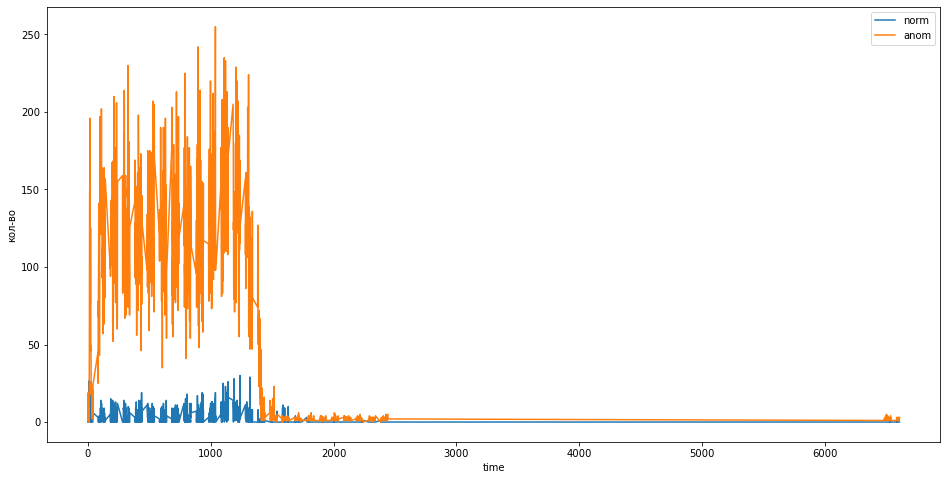

In [66]:
to_plot = data.groupby('Time', as_index=False).sum()
to_plot.columns = ['time', 'norm', 'anom']
plt.figure(figsize=(16,8))
to_plot.plot(x='time',ylabel='кол-во', figsize=(16,8))

<AxesSubplot:xlabel='time', ylabel='кол-во'>

<Figure size 1152x576 with 0 Axes>

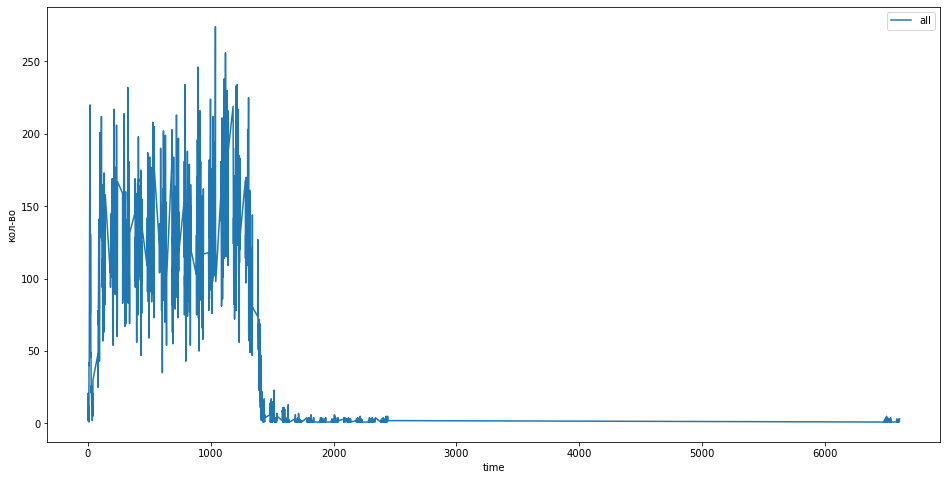

In [61]:
to_plot['all'] = to_plot.norm + to_plot.anom

to_plot_all = to_plot.drop(['norm', 'anom'], axis=1)

plt.figure(figsize=(16,8))
to_plot_all.plot(x='time',ylabel='кол-во', figsize=(16,8))